<!DOCTYPE html>
<html>
<head>
    <style>
        table {
            width: 50%;
            border-collapse: collapse;
            margin: 20px auto;
        }
        th, td {
            border: 1px solid #dddddd;
            text-align: left;
            padding: 15px;
        }
        th {
            background-color: #f2f2f2;
        }
    </style>
</head>
<body>
<center>
<img src="https://hcmut.edu.vn/img/nhanDienThuongHieu/bk_name_en.png" alt="hcmut logo"/>

<table>
    <tr>
        <th>Role</th>
        <th>Name</th>
        <th>ID</th>
    </tr>
    <tr>
        <td>Institution</td>
        <td>Ho Chi Minh University of Technology</td>
        <td></td>
    </tr>
    <tr>
        <td>Mentor</td>
        <td>Dr. Nguyen Duc Dung</td>
        <td></td>
    </tr>
    <tr>
        <td>Actor</td>
        <td>Doan Tran Cao Tri</td>
        <td>2010733</td>
    </tr>
</table>

</center>
</body>
</html>


### Setup and Import

In [1]:
!pip install datasets evaluate -q
!pip install jiwer -q
!pip install -U accelerate -q
!pip install -U transformers -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 44.4 MB/s eta 0:00:00


In [2]:
from datasets import load_dataset

In [3]:
dataset = load_dataset("TeeA/Pokemon-Captioning-Classification")
dataset

Generating train split:   0%|          | 0/4869 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1390 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/732 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image_file_path', 'image', 'labels', 'caption'],
        num_rows: 4869
    })
    validation: Dataset({
        features: ['image_file_path', 'image', 'labels', 'caption'],
        num_rows: 1390
    })
    test: Dataset({
        features: ['image_file_path', 'image', 'labels', 'caption'],
        num_rows: 732
    })
})

select and rename features

In [4]:
for split in dataset.keys():
    dataset[split] = dataset[split].select_columns(['image', 'caption']).rename_column('caption', 'text')

dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 4869
    })
    validation: Dataset({
        features: ['image', 'text'],
        num_rows: 1390
    })
    test: Dataset({
        features: ['image', 'text'],
        num_rows: 732
    })
})

In [5]:
train_ds = dataset["train"]
validation_ds = dataset["validation"]
test_ds = dataset["test"]

In [6]:
train_ds[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224>,
 'text': ' It has a yellow body with a tan belly and a tuft of fur on its head. It has three claws on each foot and a long tail with a tuft of fur on the end. Its eyes are red, and it has a small, triangular nose.'}

### Preprocessing

In [38]:
from transformers import AutoProcessor

checkpoint = "TeeA/git-base-pokemon"
processor = AutoProcessor.from_pretrained(checkpoint)
processor

GitProcessor:
- image_processor: CLIPImageProcessor {
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "do_center_crop": true,
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.48145466,
    0.4578275,
    0.40821073
  ],
  "image_processor_type": "CLIPImageProcessor",
  "image_std": [
    0.26862954,
    0.26130258,
    0.27577711
  ],
  "processor_class": "GitProcessor",
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 224
  }
}

- tokenizer: BertTokenizerFast(name_or_path='TeeA/git-base-pokemon', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=Fal

Processor for both inputs are images and texts. Which using CLIPImageProcessor for images and BertTokenizerFast for texts

In [8]:
def transforms(example_batch):
  images = [x for x in example_batch["image"]]
  captions = [x for x in example_batch["text"]]
  inputs = processor(images=images, text=captions, padding="max_length")
  inputs.update({"labels": inputs["input_ids"]})
  return inputs

In [9]:
train_ds.set_transform(transforms)
validation_ds.set_transform(transforms)
test_ds.set_transform(transforms)

### Base model

In [39]:
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained(checkpoint)

In [40]:
model

GitForCausalLM(
  (git): GitModel(
    (embeddings): GitEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(1024, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (image_encoder): GitVisionModel(
      (vision_model): GitVisionTransformer(
        (embeddings): GitVisionEmbeddings(
          (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), bias=False)
          (position_embedding): Embedding(197, 768)
        )
        (pre_layrnorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (encoder): GitVisionEncoder(
          (layers): ModuleList(
            (0-11): 12 x GitVisionEncoderLayer(
              (self_attn): GitVisionAttention(
                (k_proj): Linear(in_features=768, out_features=768, bias=True)
                (v_proj): Linear(in_features=768, out_features=768, bias=True)
             

In [12]:
import numpy as np

def preprocess_logits_for_metrics(logits, labels):
    if isinstance(logits, tuple):
       return logits
    pred_ids = torch.argmax(logits, dim=-1)
    return pred_ids, labels

In [13]:
from evaluate import load
import torch

wer = load("wer")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predicted, labels = preprocess_logits_for_metrics(logits, labels)
    decoded_labels = processor.batch_decode(labels, skip_special_tokens=True)
    decoded_predictions = processor.batch_decode(predicted, skip_special_tokens=True)
    wer_score = wer.compute(predictions=decoded_predictions, references=decoded_labels)
    return {"wer_score": wer_score}

ImportError: Using the `Trainer` with `PyTorch` requires `accelerate>=0.20.1`: Please run `pip install transformers[torch]` or `pip install accelerate -U`

https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer

# Training

In [14]:
train_ds, validation_ds, test_ds

(Dataset({
     features: ['image', 'text'],
     num_rows: 4869
 }),
 Dataset({
     features: ['image', 'text'],
     num_rows: 1390
 }),
 Dataset({
     features: ['image', 'text'],
     num_rows: 732
 }))

In [15]:
# torch.cuda.empty_cache()

In [44]:
from transformers import TrainingArguments, Trainer

model_name = checkpoint.split("/")[1]

training_args = TrainingArguments(
    output_dir=f"{model_name}",
    learning_rate=5e-5,
    num_train_epochs=50,
    fp16=True,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=4,
    save_total_limit=5,
    evaluation_strategy="epoch",
    # eval_steps=50,
    save_strategy="epoch",
    # save_steps=50,
    logging_strategy="epoch",
    # logging_steps=50,
    remove_unused_columns=False,
    push_to_hub=False,
    label_names=["labels"],
    load_best_model_at_end=True,
)

In [45]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
    preprocess_logits_for_metrics=preprocess_logits_for_metrics
)

In [46]:
trainer.train()

Epoch,Training Loss,Validation Loss,Wer Score
0,0.053600,0.130589,4.725178
1,0.042700,0.136818,4.356362
2,0.035100,0.142667,4.719215
4,0.023900,0.154419,4.550949
5,0.019800,0.160511,4.716075
6,0.016900,0.164603,4.542516
8,0.016000,0.172814,4.804354
9,0.013000,0.175425,4.822701
10,0.010700,0.179572,5.001658
12,0.007800,0.187139,4.620316


KeyboardInterrupt: ignored

In [19]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) Y
Token is valid (permission: write).
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' creden

Saving training

In [47]:
trainer.push_to_hub()

model.safetensors:   0%|          | 0.00/707M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.73k [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

events.out.tfevents.1704173166.22a4f9b1e50c.373.1:   0%|          | 0.00/15.2k [00:00<?, ?B/s]

'https://huggingface.co/TeeA/git-base-pokemon/tree/main/'

In [48]:
processor.push_to_hub("TeeA/git-base-pokemon")
model.push_to_hub("TeeA/git-base-pokemon")

CommitInfo(commit_url='https://huggingface.co/TeeA/git-base-pokemon/commit/7eb6777c57367198719968ce83f60c0d973ae7d1', commit_message='Upload GitForCausalLM', commit_description='', oid='7eb6777c57367198719968ce83f60c0d973ae7d1', pr_url=None, pr_revision=None, pr_num=None)

# Prediction

In [20]:
import torch
from PIL import Image

In [33]:
device = "cuda" if torch.cuda.is_available() else "cpu"

tokenizer_config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/862 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/707M [00:00<?, ?B/s]

it is a purple, blob - like pokemon with a wide mouth and a pair of eyes. it has a large, pink tongue that is usually hanging out.


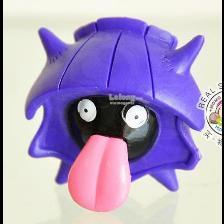

In [49]:
from transformers import AutoProcessor
from transformers import AutoModelForCausalLM

checkpoint = "TeeA/git-base-pokemon"
pr = AutoProcessor.from_pretrained(checkpoint)
mo = AutoModelForCausalLM.from_pretrained(checkpoint).to(device)

def run(image):
  inputs = pr(images=image, return_tensors="pt").to(device)
  generated_ids = mo.generate(pixel_values=inputs.pixel_values, max_length=50)
  generated_caption = pr.batch_decode(generated_ids, skip_special_tokens=True)[0]
  return generated_caption

image = Image.open("image (5).jpg")
print(run(image))
image

# Appendix

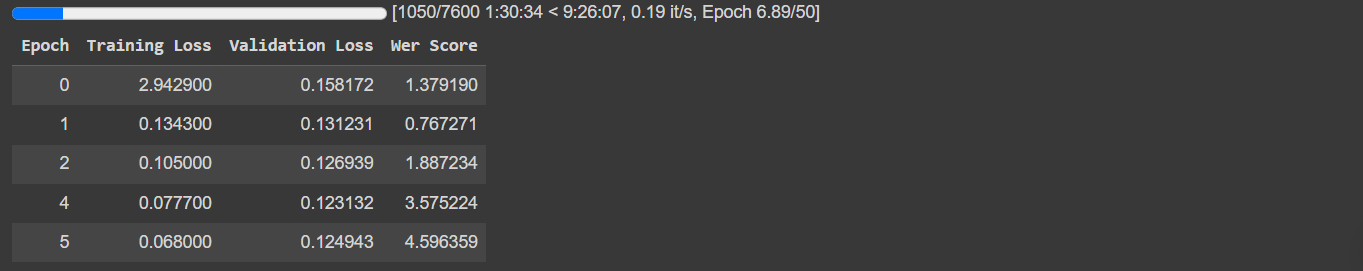
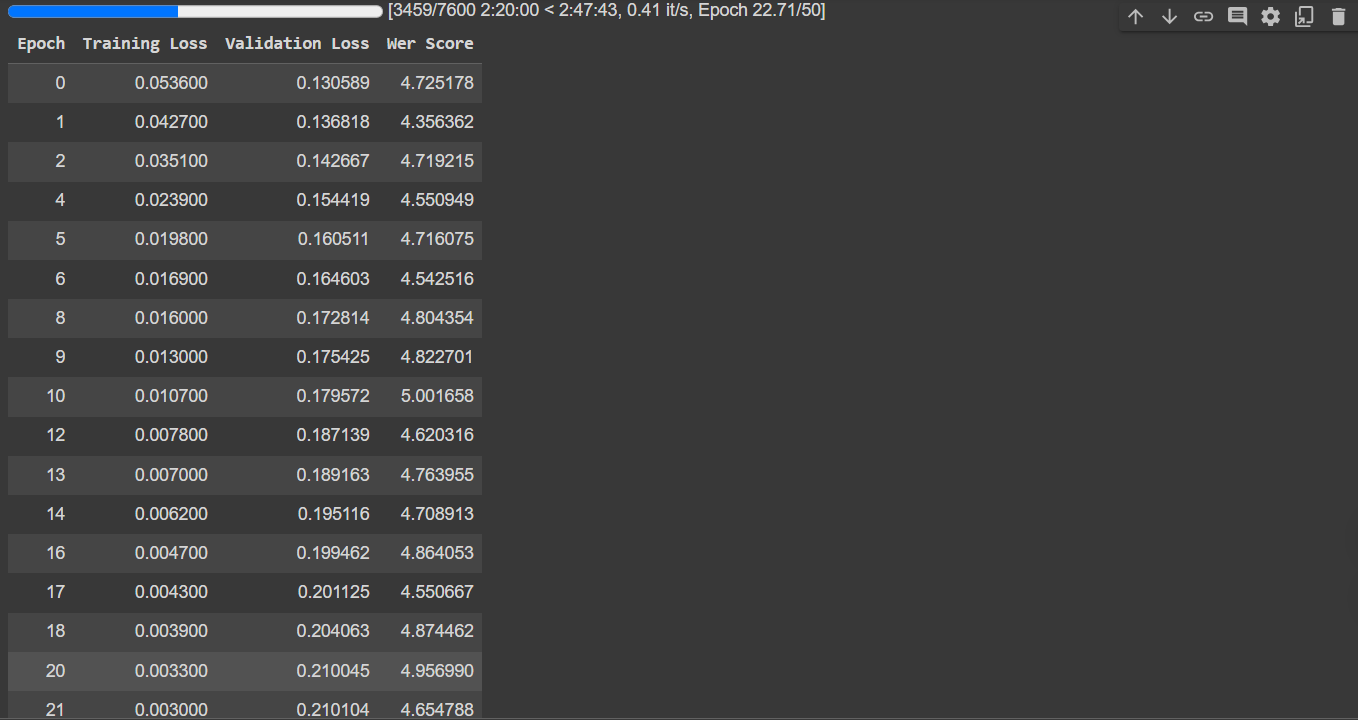